In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import os

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (common for CNNs)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (single channel if grayscale, adjust if RGB)
])

# Note: If your images are RGB, use mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]

# Optional: Separate transforms for training (with augmentation) and testing
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# Define the path to your dataset
data_dir = r'Dataset_BUSI_with_GT'

# Load the dataset
print("Loading dataset...")
full_dataset = ImageFolder(root=data_dir, transform=transform)  # Use the simpler transform for now
print("Dataset loaded successfully!")

# Verify the dataset
print(f"Total images: {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")
print(f"Class-to-index mapping: {full_dataset.class_to_idx}")

# Check if the directory exists and list subfolders
print(f"Directory exists: {os.path.exists(data_dir)}")
print(f"Subfolders: {os.listdir(data_dir)}")

Loading dataset...
Dataset loaded successfully!
Total images: 1272
Classes: ['benign', 'malignant']
Class-to-index mapping: {'benign': 0, 'malignant': 1}
Directory exists: True
Subfolders: ['benign', 'malignant']


In [5]:
# Define the test split percentage
test_split = 0.2  # 20% for testing
num_train = len(full_dataset)
indices = list(range(num_train))
split = int(np.floor(test_split * num_train))

# Shuffle indices for randomness
np.random.seed(123)  # For reproducibility
np.random.shuffle(indices)

# Split into train and test indices
train_indices, test_indices = indices[split:], indices[:split]

# Verify sizes
print(f"Training samples: {len(train_indices)}")
print(f"Test samples: {len(test_indices)}")

# Define batch size
batch_size = 32

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create data loaders
train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=test_sampler)

# Verify data loaders
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Training samples: 1018
Test samples: 254
Number of training batches: 32
Number of test batches: 8


In [6]:
import torch
import torch.nn as nn

class BreastCancerClassifier(nn.Module):
    def __init__(self, num_classes, activation=nn.ReLU()):  # Allow dynamic activation function
        super(BreastCancerClassifier, self).__init__()
        self.activation = activation  # Store activation function

        # Rescaling for grayscale images (remove if images are already RGB)
        self.rescaling = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

        # Dynamically calculate input size for `fc`
        self.fc_input_size = 64 * 28 * 28  # Assuming input 224x224
        self.fc = nn.Linear(self.fc_input_size, num_classes)

    def forward(self, x):
        if x.shape[1] == 1:  # Apply rescaling only if grayscale
            x = self.rescaling(x)

        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.conv3(x)))

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [7]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.svm import SVC

def train_with_activation(activation, device_ids, num_epochs, train_loader, test_loader, train_dataset, test_dataset):
    cnn_model = BreastCancerClassifier(num_classes=2, activation=activation)  # Updated to 2 classes
    cnn_model = nn.DataParallel(cnn_model, device_ids=device_ids)  # Utilize multiple GPUs
    cnn_model.to(device_ids[0])  # Move the model to the first GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    print(f"Activation function: {activation}")

    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device_ids[0]), labels.to(device_ids[0])  # Move tensors to the first GPU
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        accuracy = accuracy_score(all_labels, all_predictions)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Precision: {precision:.4f}, "
              f"F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    # Extract features from the CNN model for training and testing sets
    train_features = []
    test_features = []
    for images, _ in train_loader:
        images = images.to(device_ids[0])  # Move tensors to the first GPU
        features = cnn_model(images).detach().cpu().numpy()  # Convert to numpy array
        train_features.extend(features)
    for images, _ in test_loader:
        images = images.to(device_ids[0])  # Move tensors to the first GPU
        features = cnn_model(images).detach().cpu().numpy()  # Convert to numpy array
        test_features.extend(features)

    # Train an SVM classifier using the extracted features
    svm_classifier = SVC(kernel='rbf')
    svm_classifier.fit(train_features, [label for _, label in train_dataset])

    # Predict on the train set using the SVM classifier
    train_predicted_labels = svm_classifier.predict(train_features)

    # Calculate train accuracy
    train_accuracy = accuracy_score([label for _, label in train_dataset], train_predicted_labels)
    print("Train Accuracy:", train_accuracy)

    # Predict on the test set using the SVM classifier
    test_predicted_labels = svm_classifier.predict(test_features)

    # Calculate test accuracy
    test_accuracy = accuracy_score([label for _, label in test_dataset], test_predicted_labels)
    print("Test Accuracy:", test_accuracy)

Batch loaded successfully!
Image shape: torch.Size([3, 224, 224])
Labels: [0, 0, 0, 0, 0, 1, 0, 0]
Class names: ['benign', 'malignant']
Displaying and saving 8 images...
Saved image to sample_images\image_0_benign.png
Saved image to sample_images\image_1_benign.png
Saved image to sample_images\image_2_benign.png
Saved image to sample_images\image_3_benign.png
Saved image to sample_images\image_4_benign.png
Saved image to sample_images\image_5_malignant.png
Saved image to sample_images\image_6_benign.png
Saved image to sample_images\image_7_benign.png


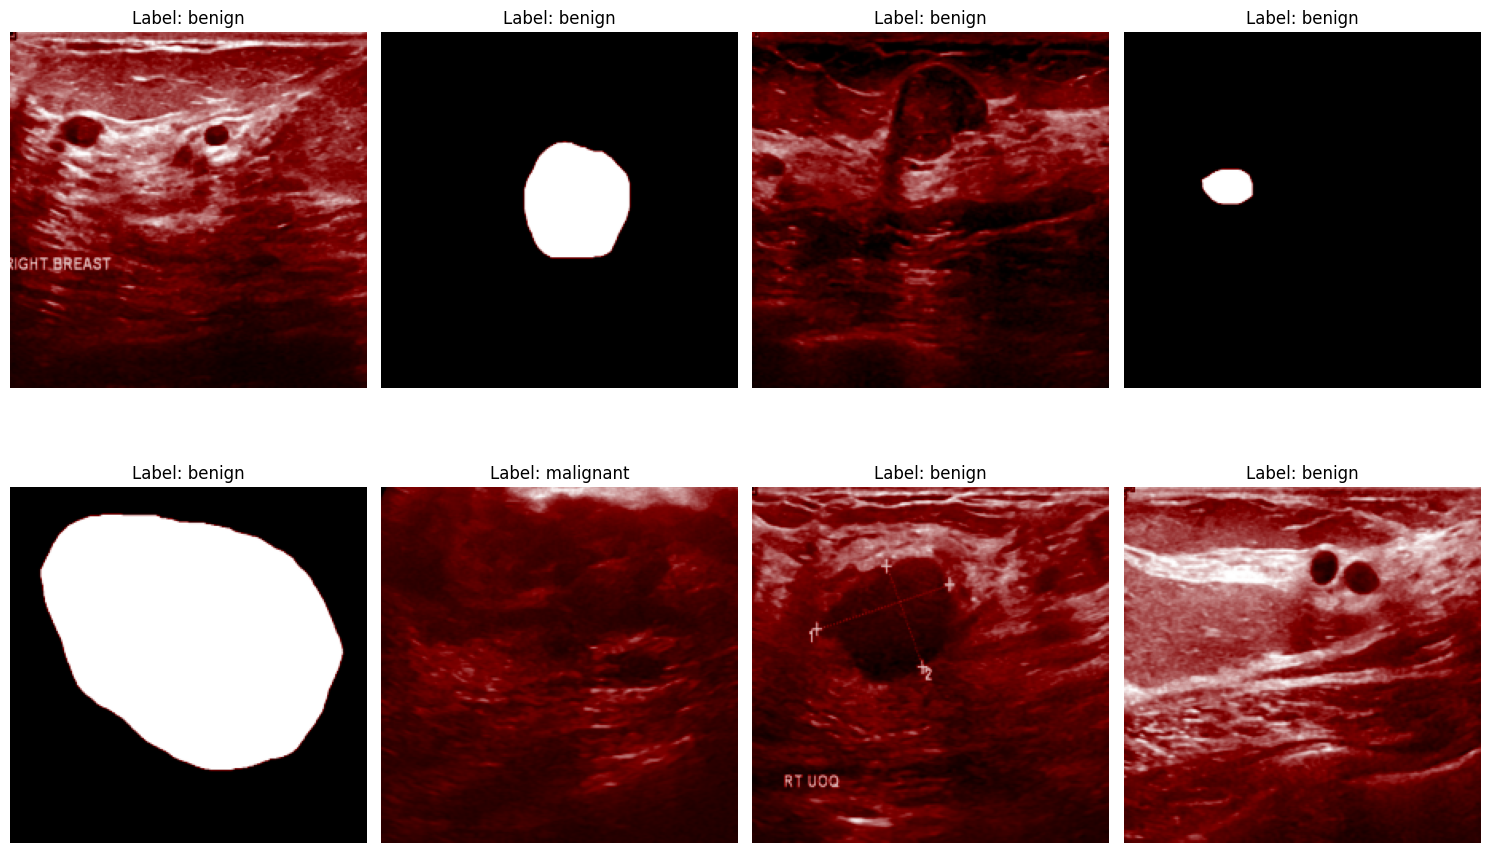

In [8]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import os

# Ensure matplotlib displays plots in the notebook
%matplotlib inline

# Function to unnormalize images (reverse the normalization for visualization)
def unnormalize(tensor, mean=[0.5], std=[0.5]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Unnormalize: (tensor * std) + mean
    return tensor

# Directory to save images
save_dir = "sample_images"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

# Get a batch of images from the train_loader
try:
    dataiter = iter(train_loader)
    images, labels = next(dataiter)  # Get the first batch
    print("Batch loaded successfully!")
    print("Image shape:", images[0].shape)  # Should be [1, 224, 224] for grayscale or [3, 224, 224] for RGB
    print("Labels:", labels[:8].tolist())
except Exception as e:
    print("Error loading batch:", e)
    raise e

# Class names from your dataset
class_names = full_dataset.classes  # ['benign', 'malignant']
print(f"Class names: {class_names}")

# Number of images to display/save (e.g., 8)
num_images = min(8, images.size(0))
print(f"Displaying and saving {num_images} images...")

# Plot the images
plt.figure(figsize=(15, 10))
for i in range(num_images):
    img = images[i]  # Tensor of shape [C, H, W]
    label = class_names[labels[i].item()]
    
    # Unnormalize the image for visualization
    img = unnormalize(img.clone())  # Clone to avoid modifying the original tensor
    
    # Convert to numpy for plotting (H, W, C)
    img_np = img.numpy().transpose(1, 2, 0)
    
    # Clip values to [0, 1] range
    img_np = np.clip(img_np, 0, 1)
    
    # Plot
    plt.subplot(2, 4, i + 1)
    plt.imshow(img_np, cmap='gray' if img.shape[0] == 1 else None)  # Use 'gray' for grayscale images
    plt.title(f"Label: {label}")
    plt.axis('off')
    
    # Save the image
    save_path = os.path.join(save_dir, f"image_{i}_{label}.png")
    vutils.save_image(img, save_path)  # Save the unnormalized tensor as an image file
    print(f"Saved image to {save_path}")

plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.svm import SVC

def train_with_activation(activation, device_ids, num_epochs, train_loader, test_loader, train_dataset, test_dataset):
    # Set device (use GPU if available, else CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Initialize the model with 2 classes (benign, malignant)
    cnn_model = BreastCancerClassifier(num_classes=2, activation=activation)

    # Enable multi-GPU training if available
    if torch.cuda.is_available() and len(device_ids) > 1 and torch.cuda.device_count() > 1:
        print(f"Using {len(device_ids)} GPUs: {device_ids}")
        cnn_model = nn.DataParallel(cnn_model, device_ids=device_ids)
    
    # Move model to the device
    cnn_model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    # Training loop
    print(f"Activation function: {activation}")
    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        accuracy = accuracy_score(all_labels, all_predictions)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, "
              f"Precision: {precision:.4f}, F1 Score: {f1:.4f}, Train Accuracy: {accuracy:.4f}")

    # Feature extraction for SVM
    cnn_model.eval()
    train_features = []
    test_features = []

    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            features = cnn_model(images).detach().cpu().numpy()
            train_features.extend(features)
        for images, _ in test_loader:
            images = images.to(device)
            features = cnn_model(images).detach().cpu().numpy()
            test_features.extend(features)

    # Train SVM classifier
    svm_classifier = SVC(kernel='rbf')
    train_labels = [label for _, label in train_dataset]
    test_labels = [label for _, label in test_dataset]
    svm_classifier.fit(train_features, train_labels)

    # Predict and calculate train accuracy
    train_predicted_labels = svm_classifier.predict(train_features)
    train_accuracy = accuracy_score(train_labels, train_predicted_labels)
    print(f"Final Train Accuracy (SVM): {train_accuracy:.4f}")

    # Predict and calculate test accuracy
    test_predicted_labels = svm_classifier.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f"Final Test Accuracy (SVM): {test_accuracy:.4f}")

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC

# Define a function to train with different activation functions
def train_with_activation(activation, device_ids):
    cnn_model = BreastCancerClassifier(num_classes=2)  # Updated to 2 classes
    cnn_model = nn.DataParallel(cnn_model, device_ids=device_ids)  # Utilize multiple GPUs
    cnn_model.to(device_ids[0])  # Move the model to the first GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    print(f"Activation function: {activation}")

    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device_ids[0]), labels.to(device_ids[0])  # Move tensors to the first GPU
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")

    # Extract features from the CNN model for training and testing sets
    train_features = []
    test_features = []
    for images, _ in train_loader:
        images = images.to(device_ids[0])  # Move tensors to the first GPU
        features = cnn_model(images).detach().cpu().numpy()  # Convert to numpy array
        train_features.extend(features)
    for images, _ in test_loader:
        images = images.to(device_ids[0])  # Move tensors to the first GPU
        features = cnn_model(images).detach().cpu().numpy()  # Convert to numpy array
        test_features.extend(features)

    # Train an SVM classifier using the extracted features
    svm_classifier = SVC(kernel='rbf')
    svm_classifier.fit(train_features, train_dataset.targets)

    # Predict on the train set using the SVM classifier
    train_predicted_labels = svm_classifier.predict(train_features)

    # Calculate train accuracy
    train_accuracy = accuracy_score(train_dataset.targets, train_predicted_labels)
    print("Train Accuracy:", train_accuracy)

    # Predict on the test set using the SVM classifier
    test_predicted_labels = svm_classifier.predict(test_features)

    # Calculate test accuracy
    test_accuracy = accuracy_score(test_dataset.targets, test_predicted_labels)
    print("Test Accuracy:", test_accuracy)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.svm import SVC

def train_with_activation(activation, device_ids):
    cnn_model = BreastCancerClassifier(num_classes=2, activation=activation)  # Updated to 2 classes
    cnn_model = nn.DataParallel(cnn_model, device_ids=device_ids)  # Utilize multiple GPUs
    cnn_model.to(device_ids[0])  # Move the model to the first GPU
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
    print(f"Activation function: {activation}")

    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device_ids[0]), labels.to(device_ids[0])  # Move tensors to the first GPU
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}")

    # Extract features from the CNN model for training and testing sets
    train_features = []
    test_features = []
    for images, _ in train_loader:
        images = images.to(device_ids[0])  # Move tensors to the first GPU
        features = cnn_model(images).detach().cpu().numpy()  # Convert to numpy array
        train_features.extend(features)
    for images, _ in test_loader:
        images = images.to(device_ids[0])  # Move tensors to the first GPU
        features = cnn_model(images).detach().cpu().numpy()  # Convert to numpy array
        test_features.extend(features)

    # Train an SVM classifier using the extracted features
    svm_classifier = SVC(kernel='rbf')
    svm_classifier.fit(train_features, [label for _, label in train_dataset])

    # Predict on the train set using the SVM classifier
    train_predicted_labels = svm_classifier.predict(train_features)

    # Calculate train accuracy
    train_accuracy = accuracy_score([label for _, label in train_dataset], train_predicted_labels)
    print("Train Accuracy:", train_accuracy)

    # Predict on the test set using the SVM classifier
    test_predicted_labels = svm_classifier.predict(test_features)

    # Calculate test accuracy
    test_accuracy = accuracy_score([label for _, label in test_dataset], test_predicted_labels)
    print("Test Accuracy:", test_accuracy)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.svm import SVC

def train_with_activation(activation, device_ids, num_epochs, train_loader, test_loader, train_dataset, test_dataset):
    # Set device (use GPU if available, else CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Initialize the model with 2 classes (benign, malignant)
    cnn_model = BreastCancerClassifier(num_classes=2, activation=activation)

    # Enable multi-GPU training if available
    if torch.cuda.is_available() and len(device_ids) > 1 and torch.cuda.device_count() > 1:
        print(f"Using {len(device_ids)} GPUs: {device_ids}")
        cnn_model = nn.DataParallel(cnn_model, device_ids=device_ids)
    
    # Move model to the device
    cnn_model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    # Training loop
    print(f"Activation function: {activation}")
    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calculate metrics
        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        accuracy = accuracy_score(all_labels, all_predictions)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, "
              f"Precision: {precision:.4f}, F1 Score: {f1:.4f}, Train Accuracy: {accuracy:.4f}")

    # Feature extraction for SVM
    cnn_model.eval()
    train_features = []
    test_features = []

    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            features = cnn_model(images).detach().cpu().numpy()
            train_features.extend(features)
        for images, _ in test_loader:
            images = images.to(device)
            features = cnn_model(images).detach().cpu().numpy()
            test_features.extend(features)

    # Train SVM classifier
    svm_classifier = SVC(kernel='rbf')
    train_labels = [label for _, label in train_dataset]
    test_labels = [label for _, label in test_dataset]
    svm_classifier.fit(train_features, train_labels)

    # Predict and calculate train accuracy
    train_predicted_labels = svm_classifier.predict(train_features)
    train_accuracy = accuracy_score(train_labels, train_predicted_labels)
    print(f"Final Train Accuracy (SVM): {train_accuracy:.4f}")

    # Predict and calculate test accuracy
    test_predicted_labels = svm_classifier.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    print(f"Final Test Accuracy (SVM): {test_accuracy:.4f}")

In [ ]:
# Set up GPU devices (will use CPU if no GPU available)
device_ids = [0, 1]

# Define number of epochs
num_epochs = 20

# Define train and test datasets using indices from cell 19
train_dataset = [(full_dataset[i][0], full_dataset[i][1]) for i in train_indices]
test_dataset = [(full_dataset[i][0], full_dataset[i][1]) for i in test_indices]

# List of activation functions to test
activation_functions = [
    nn.LeakyReLU(),
    nn.SELU(),
    nn.PReLU(),
    nn.GELU(),
    nn.ELU(),
    nn.RReLU(),
    nn.CELU(),
    nn.ReLU6()
]

# Loop through each activation function and train
for activation in activation_functions:
    print("\n" + "="*50)
    train_with_activation(activation, device_ids, num_epochs, train_loader, test_loader, train_dataset, test_dataset)


Training on device: cpu
Activation function: LeakyReLU(negative_slope=0.01)
Epoch 1/20, Loss: 20.6616, Precision: 0.6350, F1 Score: 0.6173, Train Accuracy: 0.6886
Epoch 2/20, Loss: 18.2553, Precision: 0.7105, F1 Score: 0.6692, Train Accuracy: 0.7240
Epoch 3/20, Loss: 16.8108, Precision: 0.7243, F1 Score: 0.7086, Train Accuracy: 0.7397
Epoch 4/20, Loss: 14.3614, Precision: 0.7944, F1 Score: 0.7869, Train Accuracy: 0.7996
Epoch 5/20, Loss: 11.7936, Precision: 0.8406, F1 Score: 0.8390, Train Accuracy: 0.8438
Epoch 6/20, Loss: 9.6079, Precision: 0.8745, F1 Score: 0.8734, Train Accuracy: 0.8762
Epoch 7/20, Loss: 8.0011, Precision: 0.9033, F1 Score: 0.9017, Train Accuracy: 0.9037
Epoch 8/20, Loss: 6.6377, Precision: 0.9158, F1 Score: 0.9159, Train Accuracy: 0.9165
Epoch 9/20, Loss: 5.7390, Precision: 0.9348, F1 Score: 0.9346, Train Accuracy: 0.9352
Epoch 10/20, Loss: 4.7358, Precision: 0.9457, F1 Score: 0.9456, Train Accuracy: 0.9460
Epoch 11/20, Loss: 3.5608, Precision: 0.9566, F1 Score: 0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.svm import SVC
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the PyTorch model (same as Cell 20)
class BreastCancerClassifier(nn.Module):
    def __init__(self, num_classes, activation=nn.ReLU()):
        super(BreastCancerClassifier, self).__init__()
        self.activation = activation
        self.rescaling = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc_input_size = 64 * 28 * 28  # Assuming input 224x224
        self.fc = nn.Linear(self.fc_input_size, num_classes)

    def forward(self, x):
        if x.shape[1] == 1:
            x = self.rescaling(x)
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def train_with_activation(activation, device_ids, num_epochs, train_loader, test_loader, train_dataset, test_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    cnn_model = BreastCancerClassifier(num_classes=2, activation=activation)
    if torch.cuda.is_available() and len(device_ids) > 1 and torch.cuda.device_count() > 1:
        cnn_model = nn.DataParallel(cnn_model, device_ids=device_ids)
    cnn_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    print(f"Activation function: {activation}")
    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, "
              f"Precision: {precision:.4f}, F1 Score: {f1:.4f}, Train Accuracy: {accuracy:.4f}")

    return cnn_model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.svm import SVC
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the PyTorch model (same as Cell 20)
class BreastCancerClassifier(nn.Module):
    def __init__(self, num_classes, activation=nn.ReLU()):
        super(BreastCancerClassifier, self).__init__()
        self.activation = activation
        self.rescaling = nn.Conv2d(1, 3, kernel_size=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc_input_size = 64 * 28 * 28  # Assuming input 224x224
        self.fc = nn.Linear(self.fc_input_size, num_classes)

    def forward(self, x):
        if x.shape[1] == 1:
            x = self.rescaling(x)
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def train_with_activation(activation, device_ids, num_epochs, train_loader, test_loader, train_dataset, test_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    cnn_model = BreastCancerClassifier(num_classes=2, activation=activation)
    if torch.cuda.is_available() and len(device_ids) > 1 and torch.cuda.device_count() > 1:
        cnn_model = nn.DataParallel(cnn_model, device_ids=device_ids)
    cnn_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    print(f"Activation function: {activation}")
    for epoch in range(num_epochs):
        cnn_model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, "
              f"Precision: {precision:.4f}, F1 Score: {f1:.4f}, Train Accuracy: {accuracy:.4f}")

    return cnn_model

# Train the PyTorch model
device_ids = [0, 1]
num_epochs = 20
train_dataset = [(full_dataset[i][0], full_dataset[i][1]) for i in train_indices]
test_dataset = [(full_dataset[i][0], full_dataset[i][1]) for i in test_indices]

activation = nn.LeakyReLU()
pytorch_model = train_with_activation(activation, device_ids, num_epochs, train_loader, test_loader, train_dataset, test_dataset)

# Define and convert to Keras model
def pytorch_to_keras(pytorch_model):
    inputs = Input(shape=(224, 224, 1))  # Grayscale input
    x = Conv2D(3, kernel_size=1, strides=1, padding='valid', name='rescaling')(inputs)
    x = Conv2D(16, kernel_size=3, padding='same', activation='leaky_relu', name='conv1')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='pool1')(x)
    x = Conv2D(32, kernel_size=3, padding='same', activation='leaky_relu', name='conv2')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='pool2')(x)
    x = Conv2D(64, kernel_size=3, padding='same', activation='leaky_relu', name='conv3')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='pool3')(x)
    x = Flatten(name='flatten')(x)
    x = Dropout(0.5, name='dropout')(x)
    outputs = Dense(2, activation='softmax', name='fc')(x)  # 2 classes

    keras_model = Model(inputs, outputs)

    # Transfer weights from PyTorch to Keras
    pytorch_model.eval()
    with torch.no_grad():
        # Rescaling layer
        keras_model.layers[1].set_weights([
            pytorch_model.rescaling.weight.data.permute(2, 3, 1, 0).cpu().numpy(),
            pytorch_model.rescaling.bias.data.cpu().numpy()
        ])
        # Conv1
        keras_model.layers[2].set_weights([
            pytorch_model.conv1.weight.data.permute(2, 3, 1, 0).cpu().numpy(),
            pytorch_model.conv1.bias.data.cpu().numpy()
        ])
        # Conv2
        keras_model.layers[4].set_weights([
            pytorch_model.conv2.weight.data.permute(2, 3, 1, 0).cpu().numpy(),
            pytorch_model.conv2.bias.data.cpu().numpy()
        ])
        # Conv3
        keras_model.layers[6].set_weights([
            pytorch_model.conv3.weight.data.permute(2, 3, 1, 0).cpu().numpy(),
            pytorch_model.conv3.bias.data.cpu().numpy()
        ])
        # Fully connected layer (correct index: 10, not 9)
        keras_model.layers[10].set_weights([
            pytorch_model.fc.weight.data.t().cpu().numpy(),
            pytorch_model.fc.bias.data.cpu().numpy()
        ])
         # Save as .h5
    keras_model.save('breast_cancer.h5')
    print("Saved Keras model as breast_cancer.h5")
    
    # Optional: Save as .keras (uncomment if preferred)
    # keras_model.save('breast_cancer.keras')
    # print("Saved Keras model as breast_cancer.keras")

    return keras_model      


Training on device: cpu
Activation function: LeakyReLU(negative_slope=0.01)
Epoch 1/20, Loss: 20.1387, Precision: 0.6181, F1 Score: 0.6099, Train Accuracy: 0.6807
Epoch 2/20, Loss: 17.0642, Precision: 0.7490, F1 Score: 0.7180, Train Accuracy: 0.7534
Epoch 3/20, Loss: 14.8765, Precision: 0.7765, F1 Score: 0.7757, Train Accuracy: 0.7849
Epoch 4/20, Loss: 13.5377, Precision: 0.8133, F1 Score: 0.8110, Train Accuracy: 0.8183
Epoch 5/20, Loss: 11.9834, Precision: 0.8460, F1 Score: 0.8394, Train Accuracy: 0.8468
Epoch 6/20, Loss: 9.7927, Precision: 0.8696, F1 Score: 0.8680, Train Accuracy: 0.8713
Epoch 7/20, Loss: 7.5255, Precision: 0.9027, F1 Score: 0.9027, Train Accuracy: 0.9037
Epoch 8/20, Loss: 6.9294, Precision: 0.9168, F1 Score: 0.9164, Train Accuracy: 0.9175
Epoch 9/20, Loss: 4.9965, Precision: 0.9498, F1 Score: 0.9495, Train Accuracy: 0.9499
Epoch 10/20, Loss: 3.7658, Precision: 0.9656, F1 Score: 0.9654, Train Accuracy: 0.9656
Epoch 11/20, Loss: 3.3272, Precision: 0.9636, F1 Score: 0.

Epoch 20/20, Loss: 1.1830, Precision: 0.9872, F1 Score: 0.9872, Train Accuracy: 0.9872
Saved Keras model as breast_cancer.h5


In [ ]:
# Convert and save
keras_model = pytorch_to_keras(pytorch_model)

Found 1016 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


c:\Program Files\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 797ms/step - accuracy: 0.6113 - loss: 1.4325 - val_accuracy: 0.2734 - val_loss: 0.7391
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - accuracy: 0.7952 - loss: 0.5844 - val_accuracy: 0.5664 - val_loss: 0.6882
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 444ms/step - accuracy: 0.8586 - loss: 0.3718 - val_accuracy: 0.3633 - val_loss: 0.7693
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.9104 - loss: 0.2160 - val_accuracy: 0.6953 - val_loss: 0.6316
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.9363 - loss: 0.1824 - val_accuracy: 0.5195 - val_loss: 0.7529
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - accuracy: 0.9421 - loss: 0.2016 - val_accuracy: 0.6836 - val_loss: 0.6694
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.9659 - loss: 0.0973 - val_accuracy: 0.5469 - val_loss: 0.8103
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 746ms/step - accuracy: 0.9883 - loss: 0.0567 - val_accu

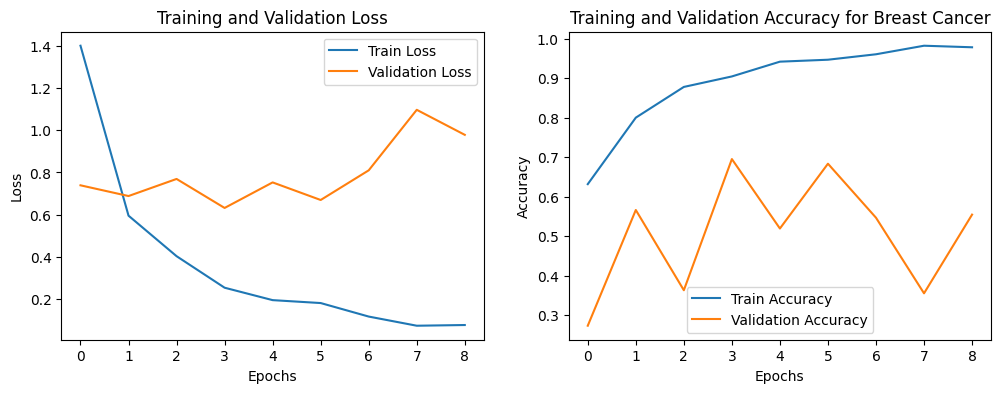

Model training complete and saved!


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

dataset_dir = 'Dataset_BUSI_with_GT'
split_dir = 'Dataset_Split'
train_dir = os.path.join(split_dir, 'train')
valid_dir = os.path.join(split_dir, 'valid')

# Function to split dataset
def split_data(dataset_dir, train_dir, valid_dir, split_ratio=0.8):
    if os.path.exists(split_dir):
        shutil.rmtree(split_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)
    
    for category in ['benign', 'malignant']:
        img_path = os.path.join(dataset_dir, category)
        images = os.listdir(img_path)
        train_images, valid_images = train_test_split(images, train_size=split_ratio, random_state=42)
        
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(valid_dir, category), exist_ok=True)
        
        for img in train_images:
            shutil.copy(os.path.join(img_path, img), os.path.join(train_dir, category, img))
        for img in valid_images:
            shutil.copy(os.path.join(img_path, img), os.path.join(valid_dir, category, img))

# Split dataset
split_data(dataset_dir, train_dir, valid_dir)

# Data Augmentation
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Save the model
model.save("models/breast_cancer_cnn.h5")



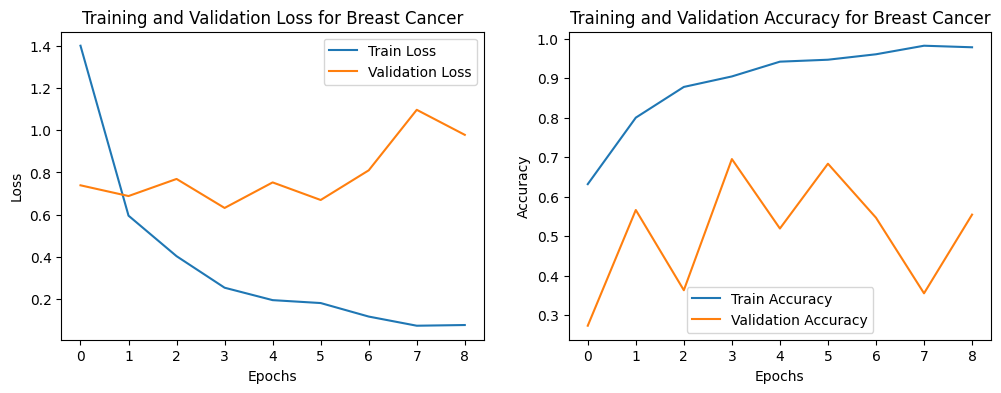

Model training complete and saved!


In [3]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Breast Cancer')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Breast Cancer')
plt.legend()

plt.show()

print("Model training complete and saved!")